In [22]:
import pandas as pd
import plotly.express as px
import numpy as np
import keras
from keras import models
from keras.layers import Embedding, Dense, Flatten
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Data extraction

In this part, we will create the dataset that we will use for our machine learning algorithms. 
We have a dataset which contains the information of all the votes made during the elaboration of the Valais constituency. 
As we focus only on the votes of the first reading that are important, we will extract the votes that correspond to the first reading. Then, with the id of the votes, we will look for the precise information on each vote (the votes of each deputy). 

In [23]:
df = pd.read_csv("../Data/Tous votes Constituante - Sheet1.csv")
df = df.drop(['startTime', 'endTime', 'filename','Unnamed: 0', 'affair', 'note', 'meaningYes', 'meaningNo', 'warning', 'linkVideo', 'attachment', 'DE_meaningYesText', 'DE_meaningNoText', 'DE_note', 'DE_affair', 'DE_section', 'DE_warning', 'DE_attachment'], axis=1)
df = df[df['section'].str.contains("1ère lecture")]
df['art_id'] = df['label'].apply(lambda x: x.rsplit(' ')[0][:-1])
df = df[~df['meaningYesText'].isnull()]

df.head()

,label,affairVoteId,meaningYesText,meaningNoText,numYes,numNo,numAbst,section,art_id
486,vote final : Ensemble de l’avant-projet tel qu...,20211209160112,Accepter,Refuser,69,28,17,1ère lecture - Vote final,vot
580,"606, vote 1 : Commission contre A-606.28 CVPO/...",20211207160250,"En l’absence d’un congé parental fédéral, l’Ét...",(néant),68,35,4,1ère lecture - Commission 6,606
593,"603, vote 4 : Commission (y.c. V/A 1-3) contre...",20211207144242,Art. 603 Enfance<br/>\r\n<ol><li>L’État et les...,(néant),90,14,1,1ère lecture - Commission 6,603
596,"602, vote 2 : Commission (y.c. V/A 1) contre A...",20211207143809,L'État et les communes développent une\r\npoli...,(néant),89,14,2,1ère lecture - Commission 6,602
632,"503, vote 2 : Résultat V/A 1 contre A-503.14 U...",20211207092238,L’État prend des mesures propres à lutter cont...,(néant),92,12,1,1ère lecture - Commission 5,503


In [24]:
def take_out_letter(x):
    l = len(x)
    if (not x.isnumeric() and '/' in x):
        return x.split('/')[0]
    elif(not x.isnumeric()):
        return x[:-1]
    else: 
        return x

In [25]:
df = df[df['art_id'].str[0].str.isnumeric()]
df['art_id'] = df['art_id'].apply(lambda x: take_out_letter(x))
df.to_csv('../Data/filtered_ds.csv')

We add manually the political orientation and a column to say if it is progessist or conservative. Those columns can take values -1, 0, 1. The file containing the values is 'filtered_ds - filtered_ds'

In [88]:
def vote_transformation(x):
    if x == 'Oui/Ja':
        return 1
    elif x == 'Non/Nein':
        return -1
    elif x == 'Abst./Enth.':
        return 0
    else: 
        return np.NaN

In [89]:
#We make the same transformation as the one made by quivotequoi.ch
def age_transformation(x):
    if x <=30: 
        return '18-30'
    elif x>65:
        return '65+'
    elif x >30 and x <45:
        return '30-45'
    else :
        return '45-65'

In the following, we will create a dataset with the precise information and the votes of each deputy on each vote that we have kept

In [90]:
df = pd.read_csv('../Data/filtered_ds - filtered_ds.csv')
ids_vote = df['affairVoteId']
full_votes = pd.DataFrame()
for ids in ids_vote:
    temp_df = pd.read_csv("../Data/{}.csv".format(ids))    
    full_votes = pd.concat([full_votes, temp_df])
temp_df = full_votes
temp_df['vote'] = temp_df['vote'].apply(lambda x: vote_transformation(x))
temp_df['Âge'] = temp_df['Âge'].apply(lambda x: age_transformation(x))
print(temp_df)

                         name   group  vote Genre    Âge        District  \
0            Matteo ABÄCHERLI    CVPO  -1.0     H  30-45            Visp   
1             Claudia ALPIGER  ZUK-VS   1.0     F  30-45            Brig   
2              Romano AMACKER    SVPO  -1.0     H  18-30  Westlich Raron   
3         Maria ARNOLD-ESCHER    CVPO  -1.0     F  45-65            Brig   
4                Peter BÄHLER    SVPO  -1.0     H    65+            Goms   
..                        ...     ...   ...   ...    ...             ...   
125        Géraldine GIANADDA     VLR   NaN     F  45-65        Martigny   
126  Géraldine GRANGES-GUENOT     UDC   NaN     F  45-65        Martigny   
127        Bernard OBERHOLZER      AC   NaN     H    65+         Monthey   
128             Damien RABOUD     UDC   NaN     H  30-45         Monthey   
129             Fabien THETAZ     AdG   NaN     H  30-45         Monthey   

       affairVoteId  
0    20211207160250  
1    20211207160250  
2    20211207160250  

In [91]:
full_votes.head()

,name,group,vote,Genre,Âge,District,affairVoteId
0,Matteo ABÄCHERLI,CVPO,-1.0,H,30-45,Visp,20211207160250
1,Claudia ALPIGER,ZUK-VS,1.0,F,30-45,Brig,20211207160250
2,Romano AMACKER,SVPO,-1.0,H,18-30,Westlich Raron,20211207160250
3,Maria ARNOLD-ESCHER,CVPO,-1.0,F,45-65,Brig,20211207160250
4,Peter BÄHLER,SVPO,-1.0,H,65+,Goms,20211207160250


In [92]:
df['art_id'] = df['art_id'].apply(lambda x: int(x))
df.rename(columns={"art_id": "artId"}, inplace=True)

We combine the two datasets in order to have the final dataset with for each MP his votes for each article. 

In [93]:
final_df = pd.merge(df, full_votes, on='affairVoteId')
final_df.head()

,Unnamed: 0,label,affairVoteId,meaningYesText,meaningNoText,numYes,numNo,numAbst,section,artId,orientation,progvscons,name,group,vote,Genre,Âge,District
0,580,"606, vote 1 : Commission contre A-606.28 CVPO/...",20211207160250,"En l’absence d’un congé parental fédéral, l’Ét...",(néant),68,35,4,1ère lecture - Commission 6,606,-1,-1,Matteo ABÄCHERLI,CVPO,-1.0,H,30-45,Visp
1,580,"606, vote 1 : Commission contre A-606.28 CVPO/...",20211207160250,"En l’absence d’un congé parental fédéral, l’Ét...",(néant),68,35,4,1ère lecture - Commission 6,606,-1,-1,Claudia ALPIGER,ZUK-VS,1.0,F,30-45,Brig
2,580,"606, vote 1 : Commission contre A-606.28 CVPO/...",20211207160250,"En l’absence d’un congé parental fédéral, l’Ét...",(néant),68,35,4,1ère lecture - Commission 6,606,-1,-1,Romano AMACKER,SVPO,-1.0,H,18-30,Westlich Raron
3,580,"606, vote 1 : Commission contre A-606.28 CVPO/...",20211207160250,"En l’absence d’un congé parental fédéral, l’Ét...",(néant),68,35,4,1ère lecture - Commission 6,606,-1,-1,Maria ARNOLD-ESCHER,CVPO,-1.0,F,45-65,Brig
4,580,"606, vote 1 : Commission contre A-606.28 CVPO/...",20211207160250,"En l’absence d’un congé parental fédéral, l’Ét...",(néant),68,35,4,1ère lecture - Commission 6,606,-1,-1,Peter BÄHLER,SVPO,-1.0,H,65+,Goms


In [109]:
counts_df = final_df[['name', 'group', 'Genre', 'vote', 'District', 'Âge', 'orientation', 'progvscons']]
counts_df['orientation'] = counts_df['orientation'].replace(0, np.NaN)
counts_df['progvscons'] = counts_df['progvscons'].replace(0, np.NaN)
#Si l'article est neutre, alors il n'influence pas la position du député 
# Cependant, s'il vote abst pour un article, alors ca influe sa position
#Les votes aucun sont pas pris en compte
counts_df['orientation'] = counts_df['vote'] * counts_df['orientation']
counts_df['progvscons'] = counts_df['vote'] * counts_df['progvscons']
counts_df = counts_df.groupby(['name', 'group', 'Âge', 'District', 'Genre']).mean()
counts_df.head(15)

/tmp/ipykernel_11353/1867274650.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_11353/1867274650.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_11353/1867274650.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

,,,,,vote,orientation,progvscons
name,group,Âge,District,Genre,,,
Adeline CRETTENAND,VLR,18-30,Martigny,F,0.000000,0.333333,0.200000
Alain DUBOSSON,UDC,18-30,Monthey,H,-0.380952,0.769231,0.761905
Alain LÉGER,PDC,30-45,Martigny,H,0.375000,0.150000,0.054054
Alain SCHÖNBETT,VLR,65+,Monthey,H,0.459459,-0.333333,-0.470588
Alex BONVIN,UDC,45-65,Sierre,H,-0.351351,0.700000,0.647059
Alina DARBELLAY,LES VERTS,45-65,Sion,F,0.125000,-0.846154,-0.782609
Arnaud DUBOIS,VLR,30-45,Monthey,H,0.390244,-0.571429,-0.763158
Bernard OBERHOLZER,AC,65+,Monthey,H,0.230769,-1.000000,-0.636364
Bernard TROILLET,PDC,65+,Martigny,H,0.560976,-0.142857,-0.263158


In [110]:
final_df.to_csv("../Data/check_votes_dep.csv")

In [111]:
counts_df = counts_df.reset_index()
counts_df.head()

,name,group,Âge,District,Genre,vote,orientation,progvscons
0,Adeline CRETTENAND,VLR,18-30,Martigny,F,0.000000,0.333333,0.200000
1,Alain DUBOSSON,UDC,18-30,Monthey,H,-0.380952,0.769231,0.761905
2,Alain LÉGER,PDC,30-45,Martigny,H,0.375000,0.150000,0.054054
3,Alain SCHÖNBETT,VLR,65+,Monthey,H,0.459459,-0.333333,-0.470588
4,Alex BONVIN,UDC,45-65,Sierre,H,-0.351351,0.700000,0.647059


We will create graphs representing the positions of the MPs on our liberal, conservative and left-right oriented graph. 

In [112]:
fig = px.scatter(counts_df, x="orientation", y="progvscons",  color='group', hover_name='name')
fig.update_xaxes(range=[-1, 1])
fig.update_yaxes(range=[-1, 1])
fig.show()

In [113]:
counts_df.to_csv("../Data/a_supprimer.csv")

In [114]:
fig = px.scatter(counts_df, x="orientation", y="progvscons",  color='District', hover_name='name')
fig.update_xaxes(range=[-1, 1])
fig.update_yaxes(range=[-1, 1])
fig.show()

In [115]:
fig = px.scatter(counts_df, x="orientation", y="progvscons",  color='Genre', hover_name='name')
fig.update_xaxes(range=[-1, 1])
fig.update_yaxes(range=[-1, 1])
fig.show()

In [116]:
fig = px.scatter(counts_df, x="orientation", y="progvscons",  color='Âge', hover_name='name')
fig.update_xaxes(range=[-1, 1])
fig.update_yaxes(range=[-1, 1])
fig.show()

In [117]:
counts_df = counts_df.drop(labels='vote', axis=1)
counts_df.head()

,name,group,Âge,District,Genre,orientation,progvscons
0,Adeline CRETTENAND,VLR,18-30,Martigny,F,0.333333,0.200000
1,Alain DUBOSSON,UDC,18-30,Monthey,H,0.769231,0.761905
2,Alain LÉGER,PDC,30-45,Martigny,H,0.150000,0.054054
3,Alain SCHÖNBETT,VLR,65+,Monthey,H,-0.333333,-0.470588
4,Alex BONVIN,UDC,45-65,Sierre,H,0.700000,0.647059


In [119]:
merged_df = pd.merge(final_df, counts_df, on=['name', 'group', 'Âge', 'Genre', 'District'], how='inner')
merged_df.rename(columns={'orientation_x': 'orientation_art', 'progvscons_x': 'progvscons_art', 'orientation_y': 'orientation_dep', 'progvscons_y': 'progvscons_dep'}, inplace=True)
#We drop the columns that do not have any value
merged_df = merged_df[~merged_df.isnull().any(axis=1)]
merged_df = merged_df[merged_df['vote'] != 0]
merged_df = merged_df.reset_index(drop=True)
merged_df.head(10)

,Unnamed: 0,label,affairVoteId,meaningYesText,meaningNoText,numYes,numNo,numAbst,section,artId,orientation_art,progvscons_art,name,group,vote,Genre,Âge,District,orientation_dep,progvscons_dep
0,580,"606, vote 1 : Commission contre A-606.28 CVPO/...",20211207160250,"En l’absence d’un congé parental fédéral, l’Ét...",(néant),68,35,4,1ère lecture - Commission 6,606,-1,-1,Matteo ABÄCHERLI,CVPO,-1.0,H,30-45,Visp,0.428571,0.368421
1,593,"603, vote 4 : Commission (y.c. V/A 1-3) contre...",20211207144242,Art. 603 Enfance<br/>\n<ol><li>L’État et les c...,(néant),90,14,1,1ère lecture - Commission 6,603,-1,-1,Matteo ABÄCHERLI,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
2,596,"602, vote 2 : Commission (y.c. V/A 1) contre A...",20211207143809,L'État et les communes développent une\npoliti...,(néant),89,14,2,1ère lecture - Commission 6,602,-1,-1,Matteo ABÄCHERLI,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
3,632,"503, vote 2 : Résultat V/A 1 contre A-503.14 U...",20211207092238,L’État prend des mesures propres à lutter cont...,(néant),92,12,1,1ère lecture - Commission 5,503,-1,-1,Matteo ABÄCHERLI,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
4,648,"418/915, vote 13 : Art. 418 commission 4 (y.c....",20211125161611,1 L’État est doté d’une ou plusieurs autorit...,1 <u>Plusieurs</u> autorités assurent en tout...,64,48,1,1ère lecture - Commission 4,418,0,1,Matteo ABÄCHERLI,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
5,657,"418, al.3n, vote 2 : Commission contre A-418.7...",20211125160409,(néant),Les organes dirigeants sont désignés par le ...,15,93,5,1ère lecture - Commission 4,418,0,1,Matteo ABÄCHERLI,CVPO,-1.0,H,30-45,Visp,0.428571,0.368421
6,658,"418, al.1, vote 1 : Commission contre A-418.74...",20211125160314,Une ou plusieurs autorités assurent le contrôl...,Une seule autorité...,83,29,1,1ère lecture - Commission 4,418,0,-1,Matteo ABÄCHERLI,CVPO,-1.0,H,30-45,Visp,0.428571,0.368421
7,665,"416a, vote 9 : Commission contre A-416a.67 AC",20211125145141,(néant),La loi fixe un quotient familial afin d’attén...,47,53,18,1ère lecture - Commission 4,416,1,1,Matteo ABÄCHERLI,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
8,687,"411a, vote 1 : Commission vs A-411a.45 AC",20211125101932,(néant),L'Etat met librement à disposition les jeux d...,56,51,6,1ère lecture - Commission 4,411,-1,1,Matteo ABÄCHERLI,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
9,740,"905, vote 5 : Commission (y.c. V/A 1-4) contre...",20211123122108,Il est institué un tribunal du droit de la fa...,(biffer),69,36,10,1ère lecture - Commission 9,905,-1,-1,Matteo ABÄCHERLI,CVPO,-1.0,H,30-45,Visp,0.428571,0.368421


We create a dataframe with only the categorical variables that we will use later for the embedding 

In [245]:
cat_df = merged_df.select_dtypes(include=['object']).copy()

We now delete the columns that we do not need anymore to start preparing the final dataset

In [120]:
merged_df = merged_df.drop(['label', 'numAbst', 'artId', 'numYes', 'numNo', 'name', 'affairVoteId', 'meaningYesText', 'meaningNoText', 'section','Unnamed: 0'], axis=1)

In [121]:
merged_df.head()

,orientation_art,progvscons_art,group,vote,Genre,Âge,District,orientation_dep,progvscons_dep
0,-1,-1,CVPO,-1.0,H,30-45,Visp,0.428571,0.368421
1,-1,-1,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
2,-1,-1,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
3,-1,-1,CVPO,1.0,H,30-45,Visp,0.428571,0.368421
4,0,1,CVPO,1.0,H,30-45,Visp,0.428571,0.368421


# One hot encoding

We will now change the categorical vairbales into dummies variables

In [124]:
prepared_df = pd.get_dummies(merged_df, columns=['Genre', 'Âge', 'District', 'group'])
prepared_df.head()

,orientation_art,progvscons_art,vote,orientation_dep,progvscons_dep,Genre_F,Genre_H,Âge_18-30,Âge_30-45,Âge_45-65,...,group_AdG,group_CSPO,group_CVPO,group_INDEP,group_LES VERTS,group_PDC,group_SVPO,group_UDC,group_VLR,group_ZUK-VS
0,-1,-1,-1.0,0.428571,0.368421,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,-1,-1,1.0,0.428571,0.368421,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,-1,-1,1.0,0.428571,0.368421,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,-1,-1,1.0,0.428571,0.368421,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,1.0,0.428571,0.368421,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [68]:
prepared_df.to_csv('dataSetForML_Onehot.csv')

# Embedding

In this part, we will use embedding techniques to deal with categorical variables. We will do embedding for the following features:
- group
- district 

We will do one hot encoding for genre and age \
To do our embedding, we chose the embedding size based on the following formula:\
embedding_size = min(50, m+1/ 2)\
where m is the number of categories for a feature


In [246]:
cat_df.head(60)

,group,Genre,Âge,District
0,CVPO,H,30-45,Visp
1,CVPO,H,30-45,Visp
2,CVPO,H,30-45,Visp
3,CVPO,H,30-45,Visp
4,CVPO,H,30-45,Visp
5,CVPO,H,30-45,Visp
6,CVPO,H,30-45,Visp
7,CVPO,H,30-45,Visp
8,CVPO,H,30-45,Visp
9,CVPO,H,30-45,Visp


In [210]:
cat_df = cat_df.drop(['label', 'meaningYesText', 'meaningNoText', 'section', 'name'], axis=1)

KeyError: "['label' 'meaningYesText' 'meaningNoText' 'section' 'name'] not found in axis"

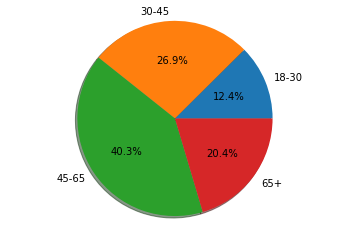

In [129]:
labels = cat_df['Âge'].astype('category').cat.categories.tolist()
counts = cat_df['Âge'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

/home/nico/Anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



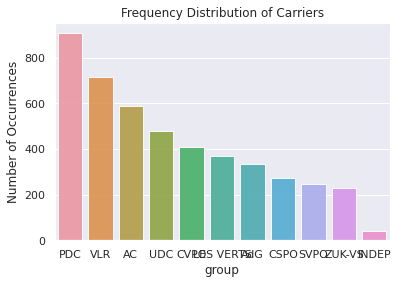

In [130]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
group_count = cat_df['group'].value_counts()
sns.set(style="darkgrid")
sns.barplot(group_count.index, group_count.values, alpha=0.9)
plt.title('Frequency Distribution of Carriers')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('group', fontsize=12)
plt.show()

In [247]:
cats = cat_df['group'].astype('category').cat.categories
cat_df['group'] = cat_df['group'].astype('category').cat.codes

In [248]:
# we add the vote 
cat_df['vote'] = merged_df['vote']

In [196]:

embedding_size_group = 6
model = models.Sequential()
model.add(Embedding(input_dim = 11, output_dim = embedding_size_group, input_length = 1, name="embedding_group"))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
model.fit(x = cat_df['group'].to_numpy(), y=cat_df['vote'].to_numpy() , epochs = 50, batch_size = 4)

Epoch 1/50
1147/1147 [==============================] - 3s 2ms/step - loss: 0.9340 - accuracy: 0.0041
Epoch 2/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9219 - accuracy: 0.0052
Epoch 3/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9225 - accuracy: 0.0000e+00
Epoch 4/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9220 - accuracy: 0.0035
Epoch 5/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9210 - accuracy: 0.0092
Epoch 6/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9213 - accuracy: 0.0000e+00
Epoch 7/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00
Epoch 8/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9216 - accuracy: 0.0000e+00
Epoch 9/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9214 - accuracy: 0.0000e+00
Epoch 10/50
1147/1147 [==============================] - 2s 2m

In [249]:
layer_g = model.get_layer('embedding_group')
group_embeddings_df = layer_g.get_weights()
group_embeddings_df

ValueError: No such layer: embedding_group. Existing layers are [<keras.layers.embeddings.Embedding object at 0x7f98c0495b80>, <keras.layers.core.flatten.Flatten object at 0x7f98c0784fa0>, <keras.layers.core.dense.Dense object at 0x7f98c07ccd30>, <keras.layers.core.dense.Dense object at 0x7f98ca7c59d0>, <keras.layers.core.dense.Dense object at 0x7f98ca793520>].

In [198]:
group_embeddings_df = pd.DataFrame(group_embeddings_df[0])
group_embeddings_df = group_embeddings_df.reset_index()
group_embeddings_df.columns = ['group', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6']
group_embeddings_df

,group,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6
0,0,-0.108287,-0.062773,-0.023715,-0.000698,-0.090546,-0.082769
1,1,-0.121636,-0.029483,-0.011808,-0.060330,-0.084380,-0.057078
2,2,-0.171827,0.254917,-0.035796,-0.272430,0.004520,0.137680
3,3,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644
4,4,0.031088,-0.270170,0.078917,0.242216,0.007547,-0.174270
5,5,-0.107065,0.063836,0.029352,-0.076935,-0.031783,0.003528
6,6,-0.167438,0.322839,0.072663,-0.331638,-0.043552,0.173563
7,7,0.261634,-0.099553,0.004347,0.251996,0.186535,0.184012
8,8,0.375083,0.001709,0.060271,0.320462,0.306612,0.328786
9,9,-0.127789,0.180640,-0.084594,-0.160178,0.063058,0.070466


### Embedding District

In [250]:
cats_district = cat_df['District'].astype('category').cat.categories
cat_df['District'] = cat_df['District'].astype('category').cat.codes

In [251]:
cat_df.head()

,group,Genre,Âge,District,vote
0,3,H,30-45,11,-1.0
1,3,H,30-45,11,1.0
2,3,H,30-45,11,1.0
3,3,H,30-45,11,1.0
4,3,H,30-45,11,1.0


In [240]:
#Jeremy Howard suggests the following solution for choosing embedding sizes:
#embedding_size = min(50, m+1/ 2)
#District embedding size is 14
#Âge embedding size is 4
embedding_size_district = 8
model = models.Sequential()
model.add(Embedding(input_dim = 14, output_dim = embedding_size_district, input_length = 1, name="embedding_district"))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
model.fit(x = cat_df['District'].to_numpy(), y=cat_df['vote'].to_numpy() , epochs = 50, batch_size = 4)

Epoch 1/50
1147/1147 [==============================] - 3s 2ms/step - loss: 0.9669 - accuracy: 0.0000e+00
Epoch 2/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9619 - accuracy: 0.0000e+00
Epoch 3/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9606 - accuracy: 0.0000e+00
Epoch 4/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9602 - accuracy: 0.0000e+00
Epoch 5/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9596 - accuracy: 0.0000e+00
Epoch 6/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9592 - accuracy: 0.0000e+00
Epoch 7/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9595 - accuracy: 0.0000e+00
Epoch 8/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9595 - accuracy: 0.0000e+00
Epoch 9/50
1147/1147 [==============================] - 2s 2ms/step - loss: 0.9590 - accuracy: 0.0000e+00
Epoch 10/50
1147/1147 [=======================

In [252]:
layer_d = model.get_layer('embedding_district')
district_embeddings_df = layer_d.get_weights()
district_embeddings_df

[array([[-0.02913838,  0.16746987,  0.11934769, -0.06833006, -0.01205898,
         -0.16574207,  0.06863725, -0.27390942],
        [ 0.05872423, -0.03008525,  0.08804335,  0.07637136,  0.05462293,
          0.07692342, -0.07536817, -0.02764381],
        [-0.09407892,  0.00852532,  0.06879131, -0.03573737,  0.10022385,
          0.04958227,  0.02101661, -0.09071258],
        [ 0.00674657,  0.0963497 , -0.38312477,  0.43566188, -0.46105814,
          0.03973494,  0.43801704,  0.36096886],
        [-0.14343092,  0.09908944,  0.17231022, -0.0301197 ,  0.04184723,
         -0.09909713,  0.14623386, -0.14508441],
        [ 0.22724003,  0.2434686 , -0.12826672, -0.30810404, -0.20499463,
         -0.12829645,  0.21337962, -0.25964862],
        [ 0.12170982, -0.05460006,  0.11935936,  0.14435454,  0.10631802,
          0.09820893, -0.1405488 , -0.12926197],
        [ 0.11057239, -0.00624148,  0.02849116,  0.02722417,  0.03487188,
          0.16171348, -0.13120957,  0.00858245],
        [ 0.0398

In [253]:
district_embeddings_df = pd.DataFrame(district_embeddings_df[0])
district_embeddings_df = district_embeddings_df.reset_index()
district_embeddings_df.columns = ['District', 'embedding_1_d', 'embedding_2_d', 'embedding_3_d', 'embedding_4_d', 'embedding_5_d', 'embedding_6_d', 'embedding_7_d', 'embedding_8_d']
district_embeddings_df

,District,embedding_1_d,embedding_2_d,embedding_3_d,embedding_4_d,embedding_5_d,embedding_6_d,embedding_7_d,embedding_8_d
0,0,-0.029138,0.167470,0.119348,-0.068330,-0.012059,-0.165742,0.068637,-0.273909
1,1,0.058724,-0.030085,0.088043,0.076371,0.054623,0.076923,-0.075368,-0.027644
2,2,-0.094079,0.008525,0.068791,-0.035737,0.100224,0.049582,0.021017,-0.090713
3,3,0.006747,0.096350,-0.383125,0.435662,-0.461058,0.039735,0.438017,0.360969
4,4,-0.143431,0.099089,0.172310,-0.030120,0.041847,-0.099097,0.146234,-0.145084
5,5,0.227240,0.243469,-0.128267,-0.308104,-0.204995,-0.128296,0.213380,-0.259649
6,6,0.121710,-0.054600,0.119359,0.144355,0.106318,0.098209,-0.140549,-0.129262
7,7,0.110572,-0.006241,0.028491,0.027224,0.034872,0.161713,-0.131210,0.008582
8,8,0.039813,-0.079123,-0.059568,-0.040762,0.123660,-0.004878,-0.195926,0.069727
9,9,-0.119103,-0.053610,-0.041642,-0.071576,0.111063,0.041902,-0.022762,0.059696


### Label genre and age

In [254]:
cat_df['Genre'] = cat_df['Genre'].astype('category').cat.codes
cat_df.head()

,group,Genre,Âge,District,vote
0,3,1,30-45,11,-1.0
1,3,1,30-45,11,1.0
2,3,1,30-45,11,1.0
3,3,1,30-45,11,1.0
4,3,1,30-45,11,1.0


In [255]:
cat_df = pd.get_dummies(data=cat_df, columns=['Âge'])

In [256]:
cat_df.head()

,group,Genre,District,vote,Âge_18-30,Âge_30-45,Âge_45-65,Âge_65+
0,3,1,11,-1.0,0,1,0,0
1,3,1,11,1.0,0,1,0,0
2,3,1,11,1.0,0,1,0,0
3,3,1,11,1.0,0,1,0,0
4,3,1,11,1.0,0,1,0,0


### Mixing with the dataset

Here we will mix the dataset with the embedded variables 

In [257]:
group_embeddings_df.head()

,group,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6
0,0,-0.108287,-0.062773,-0.023715,-0.000698,-0.090546,-0.082769
1,1,-0.121636,-0.029483,-0.011808,-0.060330,-0.084380,-0.057078
2,2,-0.171827,0.254917,-0.035796,-0.272430,0.004520,0.137680
3,3,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644
4,4,0.031088,-0.270170,0.078917,0.242216,0.007547,-0.174270


In [258]:
district_embeddings_df.head()

,District,embedding_1_d,embedding_2_d,embedding_3_d,embedding_4_d,embedding_5_d,embedding_6_d,embedding_7_d,embedding_8_d
0,0,-0.029138,0.167470,0.119348,-0.068330,-0.012059,-0.165742,0.068637,-0.273909
1,1,0.058724,-0.030085,0.088043,0.076371,0.054623,0.076923,-0.075368,-0.027644
2,2,-0.094079,0.008525,0.068791,-0.035737,0.100224,0.049582,0.021017,-0.090713
3,3,0.006747,0.096350,-0.383125,0.435662,-0.461058,0.039735,0.438017,0.360969
4,4,-0.143431,0.099089,0.172310,-0.030120,0.041847,-0.099097,0.146234,-0.145084


In [259]:
embedded_df = pd.merge(cat_df, group_embeddings_df, on=['group'], how='inner')
embedded_df.head()

,group,Genre,District,vote,Âge_18-30,Âge_30-45,Âge_45-65,Âge_65+,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6
0,3,1,11,-1.0,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644
1,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644
2,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644
3,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644
4,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644


In [260]:
print(embedded_df.shape)

(4588, 14)


In [261]:
embedded_df = pd.merge(embedded_df, district_embeddings_df, on=['District'], how='inner')
embedded_df = embedded_df.rename({"Genre":"Genre_e"}, axis=1)
embedded_df.head()

,group,Genre_e,District,vote,Âge_18-30,Âge_30-45,Âge_45-65,Âge_65+,embedding_1,embedding_2,...,embedding_5,embedding_6,embedding_1_d,embedding_2_d,embedding_3_d,embedding_4_d,embedding_5_d,embedding_6_d,embedding_7_d,embedding_8_d
0,3,1,11,-1.0,0,1,0,0,0.039741,-0.359354,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
1,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
2,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
3,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
4,3,1,11,1.0,0,1,0,0,0.039741,-0.359354,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857


In [262]:
embedded_df = embedded_df.drop(['group', 'District', 'vote'], axis=1)

In [263]:
print(embedded_df.shape)
embedded_df.head()

(4588, 19)


,Genre_e,Âge_18-30,Âge_30-45,Âge_45-65,Âge_65+,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_1_d,embedding_2_d,embedding_3_d,embedding_4_d,embedding_5_d,embedding_6_d,embedding_7_d,embedding_8_d
0,1,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
1,1,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
2,1,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
3,1,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
4,1,0,1,0,0,0.039741,-0.359354,-0.013941,0.163743,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857


In [264]:
embedded_final_df = pd.concat([merged_df, embedded_df], axis=1)
embedded_final_df = embedded_final_df.drop(['group', 'Genre', 'Âge', 'District'], axis=1)
print(embedded_final_df.shape)
embedded_final_df.head()

(4588, 24)


,orientation_art,progvscons_art,vote,orientation_dep,progvscons_dep,Genre_e,Âge_18-30,Âge_30-45,Âge_45-65,Âge_65+,...,embedding_5,embedding_6,embedding_1_d,embedding_2_d,embedding_3_d,embedding_4_d,embedding_5_d,embedding_6_d,embedding_7_d,embedding_8_d
0,-1,-1,-1.0,0.428571,0.368421,1,0,1,0,0,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
1,-1,-1,1.0,0.428571,0.368421,1,0,1,0,0,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
2,-1,-1,1.0,0.428571,0.368421,1,0,1,0,0,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
3,-1,-1,1.0,0.428571,0.368421,1,0,1,0,0,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857
4,0,1,1.0,0.428571,0.368421,1,0,1,0,0,...,0.131359,-0.067644,-0.053325,0.028136,-0.103726,0.17165,-0.195449,-0.016223,0.171781,0.131857


In [265]:
embedded_final_df.to_csv('../Data/embedded_data.csv')